In [1]:
import numpy as np
import pandas as pd
import requests
import re
import ftplib
import xarray as xr
import os
import appdirs
import time
from datetime import datetime
from io import StringIO
import matplotlib.pyplot as plt
from dateutil import relativedelta


In [2]:
def load_independent_linear(pre_trend_end='1997-01-01', post_trend_start='2000-01-01'):
    """
    Creates the predictors required for performing independent linear trends.

    Parameters
    ----------
    pre_trend_end: str, Optional. Default '1997-01-01'

    post_trend_start: str, Optional.  Default '2000-01-01'
    """
    NS_IN_YEAR = float(31556952000000000)

    start_year = pd.to_datetime('1969-01-01', format='%Y-%m-%d')
    end_year = pd.to_datetime('20181201',format = '%Y%m%d')
    
    r = relativedelta.relativedelta(end_year, start_year)
    num_months = r.years * 12 + r.months +1

    #num_months = 12 * (pd.datetime.now().year - start_year) + pd.datetime.now().month
    #num_months = 12 * (end_year - start_year) + pd.datetime.now().month
    #num_months = ((end_year - start_year)/np.timedelta64(1, 'M'))
    print('num months', num_months)

    index = pd.date_range('1969-01', periods=num_months, freq='M').to_period(freq='M')
        
    pre_delta = -1*(index.to_timestamp() - pd.to_datetime(pre_trend_end)).values
    post_delta = (index.to_timestamp() - pd.to_datetime(post_trend_start)).values
        

    assert(pre_delta.dtype == np.dtype('<m8[ns]'))
    assert(post_delta.dtype == np.dtype('<m8[ns]'))
    ## np.dtype('datetime64[ns]') would equal np.dtype('>M8[ns]')

    #time difference in number of years
    pre_delta = pre_delta.astype(np.int64) / NS_IN_YEAR
    post_delta = post_delta.astype(np.int64) / NS_IN_YEAR
    
    print('pre',pre_delta[0:10])
    print('post', post_delta[0:10])

    pre_const = np.ones_like(pre_delta)
    pre_const[pre_delta < 0] = 0

    post_const = np.ones_like(post_delta)
    post_const[post_delta < 0] = 0

    # Check if we need a gap constant
    pre_plus_post = pre_const + post_const
    if np.any(pre_plus_post == 0):
        need_gap_constant = True

        gap_constant = np.ones_like(pre_plus_post)
        gap_constant[pre_plus_post == 1] = 0

        gap_constant = pd.Series(gap_constant, index=index, name='gap_const')
    else:
        need_gap_constant = False

    pre_delta[pre_delta < 0] = 0
    post_delta[post_delta < 0] = 0

    pre = pd.Series(-1*pre_delta / 10, index=index, name='pre')
    post = pd.Series(post_delta / 10, index=index, name='post')

    post_const = pd.Series(post_const, index=index, name='post_const')
    pre_const = pd.Series(pre_const, index=index, name='pre_const')

    if need_gap_constant:
        data = pd.concat([pre, post, post_const, pre_const, gap_constant], axis=1)
    else:
        data = pd.concat([pre, post, post_const, pre_const], axis=1)

    return data

In [3]:
trends = load_independent_linear(pre_trend_end='1997-01-01', post_trend_start='2000-01-01')

num months 600
pre [ 28.00057496  27.91569984  27.83903845  27.75416333  27.67202612
  27.587151    27.50501379  27.42013867  27.33526356  27.25312635]
post [-30.99858313 -30.91370802 -30.83704662 -30.7521715  -30.67003429
 -30.58515918 -30.50302196 -30.41814685 -30.33327173 -30.25113452]


In [4]:
trends

,pre,post,post_const,pre_const,gap_const
1969-01,-2.800057,0.000000,0.0,1.0,0.0
1969-02,-2.791570,0.000000,0.0,1.0,0.0
1969-03,-2.783904,0.000000,0.0,1.0,0.0
1969-04,-2.775416,0.000000,0.0,1.0,0.0
1969-05,-2.767203,0.000000,0.0,1.0,0.0
1969-06,-2.758715,0.000000,0.0,1.0,0.0
1969-07,-2.750501,0.000000,0.0,1.0,0.0
1969-08,-2.742014,0.000000,0.0,1.0,0.0
1969-09,-2.733526,0.000000,0.0,1.0,0.0
1969-10,-2.725313,0.000000,0.0,1.0,0.0


In [5]:
def load_enso(lag_months=0, begin = 1969, end = 2018):
    """
    Downloads the ENSO from https://www.esrl.noaa.gov/psd/enso/mei/data/meiv2.data

    for uccle https://www.esrl.noaa.gov/psd/enso/mei.old/table.html
    Parameters
    ----------
    lag_months : int, Optional. Default 0
        The numbers of months of lag to introduce to the ENSO signal
    """
    #data = pd.read_table('https://www.esrl.noaa.gov/psd/enso/mei/data/meiv2.data', skiprows=1, skipfooter=4, sep='\s+',
    #                     index_col=0, engine='python', header=None)
    data = pd.read_table('/home/poyraden/MLR_Uccle/Files/enso_mei.dat', skiprows=1,  sep='\s+',
                         index_col=0, engine='python', header=None)
    
    end = end + 1
    indb = begin - data.index[0]
    inde = end - data.index[0]

    datan = data[indb:inde]
    datan = datan.stack()

    datan = datan[datan > -998]
    datan.index = pd.date_range(start=str(begin), periods=len(datan), freq='M').to_period()

    datan = datan.shift(lag_months)

    return datan


In [6]:
enso = load_enso(lag_months=0)

/home/poyraden/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: read_table is deprecated, use read_csv instead.
  


In [7]:
print(enso[0:10])
print(enso.index, enso['1969-02'])

1969-01    0.670
1969-02    0.849
1969-03    0.458
1969-04    0.622
1969-05    0.674
1969-06    0.801
1969-07    0.490
1969-08    0.212
1969-09    0.162
1969-10    0.496
Freq: M, dtype: float64
PeriodIndex(['1969-01', '1969-02', '1969-03', '1969-04', '1969-05', '1969-06',
             '1969-07', '1969-08', '1969-09', '1969-10',
             ...
             '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
             '2018-08', '2018-09', '2018-10', '2018-11'],
            dtype='period[M]', length=599, freq='M') 0.849


In [11]:
def load_eesc():
    """
    Calculates an EESC from the polynomial values [9.451393e-10, -1.434144e-7, 8.5901032e-6, -0.0002567041,
    0.0040246245, -0.03355533, 0.14525718, 0.71710218, 0.1809734]
    """
    poly = [9.451393e-10, -1.434144e-7, 8.5901032e-6, -0.0002567041,
            0.0040246245, -0.03355533, 0.14525718, 0.71710218, 0.1809734]
    np.polyval(poly, 1)

    num_months = 12 * (pd.datetime.now().year - 1979) + pd.datetime.now().month
    num_months = 600
    index = pd.date_range('1969-01-01', periods=num_months, freq='M').to_period(freq='M')
    return pd.Series([np.polyval(poly, month/12) for month in range(num_months)], index=index)



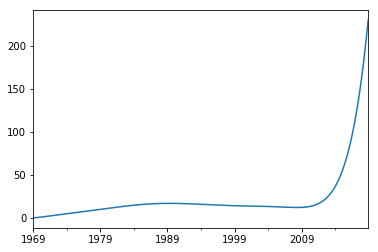

In [13]:
eesc = load_eesc()
eesc.plot()

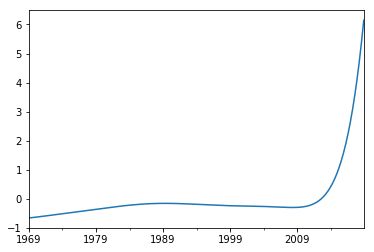

In [18]:
nor.plot()

In [8]:
def load_qbo(pca=3):
    """
    Loads the QBO from http://www.geo.fu-berlin.de/met/ag/strat/produkte/qbo/qbo.dat.  If pca is set to an integer (default 3) then
    that many principal components are taken.  If pca is set to 0 then the raw QBO data is returned.

    Parameters
    ----------
    pca : int, optional.  Default 3.
    """
    import sklearn.decomposition as decomp
    # yymm date parser
    def date_parser(s):
        s = int(s)
        return pd.datetime(2000 + s // 100 if (s // 100) < 50 else 1900 + s // 100, s % 100, 1)

    data = pd.read_fwf(StringIO(requests.get('http://www.geo.fu-berlin.de/met/ag/strat/produkte/qbo/qbo.dat').text),
                       skiprows=200, header=None,
                       colspecs=[(0, 5), (6, 10), (12, 16), (19, 23), (26, 30), (33, 37), (40, 44), (47, 51), (54, 58)],
                         delim_whitespace=True, index_col=1, parse_dates=True, date_parser=date_parser,
                         names=['station', 'month', '70', '50', '40', '30', '20', '15', '10'])
    data.index = data.index.to_period(freq='M')

    data.drop('station', axis=1, inplace=True)
    data = data[:-1]

    if pca > 0:
        from string import ascii_lowercase
        pca_d = decomp.PCA(n_components=pca)
        for idx, c in zip(range(pca), ascii_lowercase):
            data['pc' + c] = pca_d.fit_transform(data.values).T[idx, :]

    return data

In [9]:
qbo = load_qbo(pca=2)
qbo[0:10]


,70,50,40,30,20,15,10,pca,pcb
month,,,,,,,,,
1968-12,-10,-179,-295,-138,146,209,166,419.828885,326.294524
1969-01,-32,-167,-294,4,144,167,146,428.201540,233.844068
1969-02,-50,-143,-218,61,120,116,116,385.031809,140.065253
1969-03,-71,-162,-94,104,133,158,152,449.583999,65.058831
1969-04,-84,-85,62,151,162,159,203,488.889295,-70.067335
1969-05,-59,70,84,151,166,175,215,476.392511,-141.742200
1969-06,6,86,128,140,207,160,146,444.204386,-206.841117
1969-07,89,139,133,151,161,156,96,377.002873,-251.134256
1969-08,84,157,168,138,147,131,43,323.873720,-289.211308


In [10]:
qbo['qboA_nor'] = (qbo.pca - qbo.pca.mean())/qbo.pca.std()
qbo['qboB_nor'] = (qbo.pcb - qbo.pcb.mean())/qbo.pcb.std()

In [11]:
qbo.qboA_nor.mean(), qbo.qboA_nor.std()

(-1.0459952463410566e-17, 0.9999999999999996)

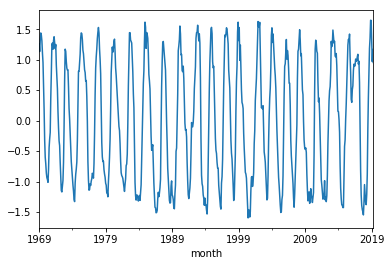

In [12]:
qbo.qboA_nor.plot()

In [13]:
def load_solar():
    """
    Gets the solar F10.7 from 'http://www.spaceweather.ca/data-donnee/sol_flux/sx-5-mavg-eng.php'.
    """
    sess = requests.session()
    sess.get('https://omniweb.gsfc.nasa.gov/')

    #today = datetime.today()
    today = pd.to_datetime('20181231', format='%Y%m%d', errors='ignore')

    page = sess.get('https://omniweb.gsfc.nasa.gov/cgi/nx1.cgi?activity=retrieve&res=daily&spacecraft=omni2_daily&start_date=19690101&end_date={}&vars=50&scale=Linear&ymin=&ymax=&charsize=&symsize=0.5&symbol=0&imagex=640&imagey=480'.format(today.strftime('%Y%M%d')))
    print('pgae', 'https://omniweb.gsfc.nasa.gov/cgi/nx1.cgi?activity=retrieve&res=daily&spacecraft=omni2_daily&start_date=19690101&end_date={}&vars=50&scale=Linear&ymin=&ymax=&charsize=&symsize=0.5&symbol=0&imagex=640&imagey=480'.format(today.strftime('%Y%M%d')))
    # Won't have data for today, find the largest possible range
    ##last_day = page.text[page.text.rindex('19631128 - ') + 11:page.text.rindex('19631128 - ') + 8 + 11]
    ##page = sess.get('https://omniweb.gsfc.nasa.gov/cgi/nx1.cgi?activity=retrieve&res=daily&spacecraft=omni2_daily&start_date=19631128&end_date={}&vars=50&scale=Linear&ymin=&ymax=&charsize=&symsize=0.5&symbol=0&imagex=640&imagey=480'.format(last_day))

    data = StringIO(page.text[page.text.rindex('YEAR'):page.text.rindex('<hr>')])

    solar = pd.read_csv(data, delimiter='\s+')
    solar = solar[:-1]
    print('zero', solar[0:10])
    solar['dt'] = pd.to_datetime((solar['YEAR'].astype('int') * 1000) + solar['DOY'].astype(int), format='%Y%j')
    print('one', solar[0:10])
    solar = solar.set_index(keys='dt')
    print('two', solar[0:10])
    solar = solar.where(solar['1'] != 999.9)
    #month;y means
    solar = solar.resample('MS').mean()
    solar['solar_mm'] = solar['1']
    solar =  solar.drop(columns='1')
    solar =  solar.drop(columns='DOY')
    solar =  solar.drop(columns='HR')

    
    #print('here',solar['1'].rename('f10.7').to_period(freq='M'))
    return solar
#.rename('solar_mm').to_period(freq='M')

In [3]:
def load_giss_aod():
    """
    Loads the giss aod index from giss
    """
    filename = 'tau_map_2012-12.nc'

    save_path = os.path.join(appdirs.user_data_dir(), filename)
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Only fetch from the ftp if the file does not exist
    if not os.path.exists(save_path) or time.time():
        r = requests.get(r'https://data.giss.nasa.gov/modelforce/strataer/tau_map_2012-12.nc')

        with open(save_path, 'wb') as f:
            f.write(r.content)

    data = xr.open_dataset(save_path)

    data = data.mean(dim='lat')['tau'].to_dataframe()

    data.index = data.index.map(lambda row: pd.datetime(int(row.year), int(row.month), 1)).to_period(freq='M')
    data.index.names = ['time']

    # Find the last non-zero entry and extend to the current date
    last_nonzero_idx = data[data['tau'] != 0].index[-1]
    last_nonzero_idx = np.argmax(data.index == last_nonzero_idx)

    # Extend the index to approximately now
    num_months = 12 * (pd.datetime.now().year - data.index[0].year) + pd.datetime.now().month
    index = pd.date_range(data.index[0].to_timestamp(), periods=num_months, freq='M').to_period(freq='M')

    # New values
    vals = np.zeros(len(index))
    vals[:last_nonzero_idx] = data['tau'].values[:last_nonzero_idx]
    vals[last_nonzero_idx:] = data['tau'].values[last_nonzero_idx]

    new_aod = pd.Series(vals, index=index, name='aod')

    return new_aod

In [13]:
aod = load_giss_aod()
type (aod)
aod[1500:1510]


1975-01    0.022783
1975-02    0.027108
1975-03    0.031404
1975-04    0.035817
1975-05    0.040117
1975-06    0.036904
1975-07    0.033992
1975-08    0.031317
1975-09    0.028792
1975-10    0.026496
Freq: M, Name: aod, dtype: float64

In [16]:
aod_nor = (aod - np.mean(aod))/np.std(aod)
aod_nor[1500:1510]
aod = aod['1975-01':'1978-01']
aod

1975-01    0.022783
1975-02    0.027108
1975-03    0.031404
1975-04    0.035817
1975-05    0.040117
1975-06    0.036904
1975-07    0.033992
1975-08    0.031317
1975-09    0.028792
1975-10    0.026496
1975-11    0.024400
1975-12    0.022400
1976-01    0.020600
1976-02    0.019000
1976-03    0.017492
1976-04    0.016092
1976-05    0.014813
1976-06    0.013600
1976-07    0.012621
1976-08    0.011625
1976-09    0.010613
1976-10    0.009787
1976-11    0.008979
1976-12    0.008292
1977-01    0.007696
1977-02    0.007108
1977-03    0.006508
1977-04    0.005983
1977-05    0.005496
1977-06    0.005100
1977-07    0.004692
1977-08    0.004288
1977-09    0.003992
1977-10    0.003675
1977-11    0.003388
1977-12    0.003108
1978-01    0.002887
Freq: M, Name: aod, dtype: float64

In [14]:
solar = load_solar()

pgae https://omniweb.gsfc.nasa.gov/cgi/nx1.cgi?activity=retrieve&res=daily&spacecraft=omni2_daily&start_date=19690101&end_date=20180031&vars=50&scale=Linear&ymin=&ymax=&charsize=&symsize=0.5&symbol=0&imagex=640&imagey=480
zero    YEAR   DOY   HR      1
0  1969   1.0  0.0  139.9
1  1969   2.0  0.0  142.1
2  1969   3.0  0.0  144.1
3  1969   4.0  0.0  154.5
4  1969   5.0  0.0  162.5
5  1969   6.0  0.0  178.9
6  1969   7.0  0.0  183.0
7  1969   8.0  0.0  183.1
8  1969   9.0  0.0  183.3
9  1969  10.0  0.0  169.3
one    YEAR   DOY   HR      1         dt
0  1969   1.0  0.0  139.9 1969-01-01
1  1969   2.0  0.0  142.1 1969-01-02
2  1969   3.0  0.0  144.1 1969-01-03
3  1969   4.0  0.0  154.5 1969-01-04
4  1969   5.0  0.0  162.5 1969-01-05
5  1969   6.0  0.0  178.9 1969-01-06
6  1969   7.0  0.0  183.0 1969-01-07
7  1969   8.0  0.0  183.1 1969-01-08
8  1969   9.0  0.0  183.3 1969-01-09
9  1969  10.0  0.0  169.3 1969-01-10
two             YEAR   DOY   HR      1
dt                                
19

In [15]:
solar

,solar_mm
dt,
1969-01-01,147.845161
1969-02-01,151.478571
1969-03-01,170.622581
1969-04-01,156.536667
1969-05-01,148.703226
1969-06-01,167.283333
1969-07-01,141.080645
1969-08-01,146.612903
1969-09-01,138.746667


In [16]:
solar['nor'] = (solar.solar_mm - np.mean(solar.solar_mm))/np.std(solar.solar_mm)
solar[0:10]

,solar_mm,nor
dt,,
1969-01-01,147.845161,0.574575
1969-02-01,151.478571,0.653585
1969-03-01,170.622581,1.069876
1969-04-01,156.536667,0.763574
1969-05-01,148.703226,0.593234
1969-06-01,167.283333,0.997263
1969-07-01,141.080645,0.427479
1969-08-01,146.612903,0.547780
1969-09-01,138.746667,0.376726


In [2]:
from LOTUS_regression.predictors import load_data

predictors = load_data('pred_baseline_ilt.csv')
predictors[0:10]

,enso,trop,solar,qboA,qboB,aod,linear_pre,linear_post,pre_const,post_const,gap_cons
time,,,,,,,,,,,
1977-02-01,0.190846,0.056230,-0.878373,-0.893729,0.868484,-0.322758,-1.991554,0.0,1.0,0.0,0.0
1977-03-01,0.055599,-0.150136,-0.970547,-0.950740,0.958572,-0.349183,-1.983887,0.0,1.0,0.0,0.0
1977-04-01,0.465378,0.482685,-0.921855,-0.707242,1.281763,-0.372305,-1.975400,0.0,1.0,0.0,0.0
1977-05-01,0.236265,0.701358,-0.855725,-0.212917,1.437930,-0.393775,-1.967186,0.0,1.0,0.0,0.0
1977-06-01,0.362429,0.511586,-0.590299,0.430208,1.491102,-0.411209,-1.958699,0.0,1.0,0.0,0.0
1977-07-01,0.789366,-1.254606,-0.809299,0.872887,1.223776,-0.429192,-1.950485,0.0,1.0,0.0,0.0
1977-08-01,0.616774,-0.304554,-0.755398,1.058688,1.090348,-0.446993,-1.941997,0.0,1.0,0.0,0.0
1977-09-01,0.722752,-1.050463,-0.452151,1.183997,0.725692,-0.460022,-1.933510,0.0,1.0,0.0,0.0
1977-10-01,0.910483,-1.002566,-0.552705,1.352515,0.472493,-0.473968,-1.925296,0.0,1.0,0.0,0.0


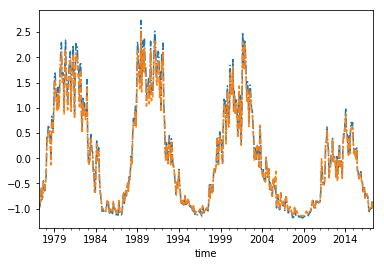

In [27]:
## SOLAR
ax = plt.gca()

solar.loc['1977-02-01':'2017-06-01'].nor.plot(style = "-.")
predictors.solar.plot( style = "--")
plt.savefig('Solar.pdf')

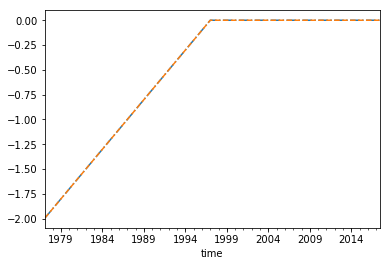

In [28]:
#PRE
trends.loc['1977-02-01':'2017-06-01'].pre.plot(style = "-.")
predictors.linear_pre.plot(style = "--")
plt.savefig('Linear_Pre.pdf')

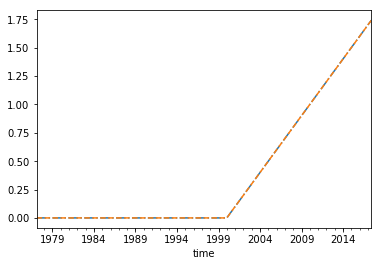

In [29]:
# POST
#PRE
trends.loc['1977-02-01':'2017-06-01'].post.plot(style = "-.")
predictors.linear_post.plot(style = "--")
plt.savefig('Linear_post.pdf')

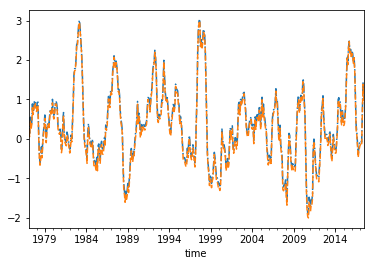

In [30]:
#ENSO
enso.loc['1977-02-01':'2017-06-01'].plot(style = "-.")
predictors.enso.plot(style = "--")
plt.savefig('ENSO.pdf')

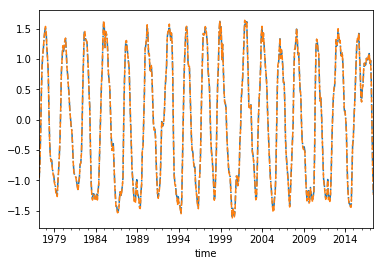

In [31]:
qbo.loc['1977-02-01':'2017-06-01'].qboA_nor.plot(style = "-.")
predictors.qboA.plot(style = "--")
plt.savefig('QBO1.pdf')

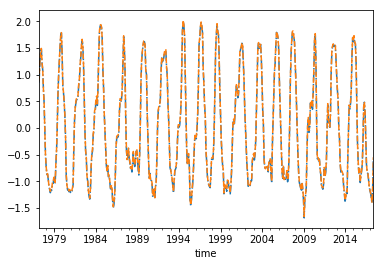

In [32]:
qbo.loc['1977-02-01':'2017-06-01'].qboB_nor.plot(style = "-.")
predictors.qboB.plot(style = "--")
plt.savefig('QBO2.pdf')